In [ ]:
# to access the google drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········


In [ ]:
import os
import numpy as np
np.random.seed(777)
import math
import keras
import keras.backend as K
import h5py
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, SGD, RMSprop
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input, Activation, merge, Dense, Flatten, Dropout, concatenate
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization, add, GlobalAveragePooling2D
from keras.utils.np_utils import to_categorical
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score,roc_curve, confusion_matrix, roc_auc_score, auc, f1_score
from keras.regularizers import l2
from keras.applications.xception import Xception, preprocess_input
from keras.applications.mobilenet import MobileNet
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications import DenseNet201
from keras.applications import DenseNet121

from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Lambda,Concatenate
from keras.layers import SeparableConv2D, AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D, Add

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

In [ ]:
# directories of train, test and validation
train_dir = '/content/drive/My Drive/data_v3/train/'
test_dir = '/content/drive/My Drive/data_v3/test/'
valid_dir = '/content/drive/My Drive/data_v3/test/'

extracted_features_dir = '/content/drive/My Drive/data_v3/extracted_features/'


In [ ]:
import keras
import tensorflow as tf
import keras.backend as K

print("Keras Version", keras.__version__)
print("tensorflow Version", tf.__version__)


In [5]:
# train , test and valid size

batch_size = 32
img_height, img_width = 224, 224
input_shape = (img_height, img_width, 3)
epochs = 1000


for root,dirs,files in os.walk(train_dir):
    print (root, len(files))

print("*"*30)
for root,dirs,files in os.walk(test_dir):
    print (root, len(files))

print("*"*30)
for root,dirs,files in os.walk(valid_dir):
    print (root, len(files))

/content/drive/My Drive/data_v3/train/ 0
/content/drive/My Drive/data_v3/train/COVID-19 635
/content/drive/My Drive/data_v3/train/normal 7082
/content/drive/My Drive/data_v3/train/CAP 4836
******************************
/content/drive/My Drive/data_v3/test/ 0
/content/drive/My Drive/data_v3/test/normal 885
/content/drive/My Drive/data_v3/test/COVID-19 136
/content/drive/My Drive/data_v3/test/CAP 604
******************************
/content/drive/My Drive/data_v3/test/ 0
/content/drive/My Drive/data_v3/test/normal 885
/content/drive/My Drive/data_v3/test/COVID-19 136
/content/drive/My Drive/data_v3/test/CAP 604


In [6]:
random_seed = np.random.seed(1142)

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    validation_split= 0.25,
    zoom_range=0.2,
    shear_range=0.2)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'training',
    class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'validation',
    class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1. / 255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    class_mode='categorical')

Found 9416 images belonging to 3 classes.
Found 3137 images belonging to 3 classes.
Found 1625 images belonging to 3 classes.


In [7]:
nb_train_samples = len(train_generator.filenames)
nb_validation_samples = len(validation_generator.filenames)
predict_size_train = int(math.ceil(nb_train_samples / batch_size))
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))

nb_test_samples = len(test_generator.filenames)
predict_size_test = int(math.ceil(nb_test_samples / batch_size))

# nb_test_without_aug_samples = len(test_generator_without_aug.filenames)
# predict_size_test_without_aug = int(math.ceil(nb_test_without_aug_samples / batch_size))

num_classes = len(train_generator.class_indices)

print("nb_train_samples:", nb_train_samples)
print("nb_validation_samples:", nb_validation_samples)
print("\npredict_size_train:", predict_size_train)
print("predict_size_validation:", predict_size_validation)
# print("nb_test_without_aug_samples:", nb_test_without_aug_samples)
# print("predict_size_test_without_aug_samples:", predict_size_test_without_aug)
print("nb_test_samples:", nb_test_samples)
print("predict_size_test:", predict_size_test)

print("\n num_classes:", num_classes)

nb_train_samples: 9416
nb_validation_samples: 3137

predict_size_train: 295
predict_size_validation: 99
nb_test_samples: 1625
predict_size_test: 51

 num_classes: 3


In [8]:
from keras.applications import VGG19

input_tensor = Input(shape = input_shape)  

base_model =VGG19(input_shape= input_shape,weights='imagenet', include_top=False, input_tensor=input_tensor)

x = base_model.output
x = GlobalAveragePooling2D()(x)

predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=input_tensor,outputs=predictions)

80142336/80134624 [==============================] - 1s 0us/step


In [9]:
from keras.applications.densenet import DenseNet169
from keras.applications.inception_v3 import InceptionV3
from keras.applications.nasnet import NASNetMobile
from keras.applications import VGG19

input_tensor = Input(shape = input_shape)  

base_model1=NASNetMobile(input_shape= input_shape,weights='imagenet', include_top=False, input_tensor=input_tensor)
base_model2=InceptionV3(input_shape= input_shape,weights='imagenet', include_top=False, input_tensor=input_tensor)
base_model3=DenseNet201(input_shape= input_shape,weights='imagenet', include_top=False, input_tensor=input_tensor)
base_model4=VGG19(input_shape= input_shape,weights='imagenet', include_top=False, input_tensor=input_tensor)

x1 = base_model1.output
x1 = GlobalAveragePooling2D()(x1)

x2 = base_model2.output
x2 = GlobalAveragePooling2D()(x2)

x3 = base_model3.output
x3 = GlobalAveragePooling2D()(x3)

x4 = base_model4.output
x4 = GlobalAveragePooling2D()(x4)

merge = concatenate([x1, x2, x3 , x4])
predictions = Dense(num_classes, activation='softmax')(merge)

model = Model(inputs=input_tensor,outputs=predictions)

74842112/74836368 [==============================] - 0s 0us/step


In [12]:
bottleneck_final_model = Model(inputs=model.input, outputs=merge)

In [ ]:
#for i, layer in enumerate(bottleneck_final_model.layers):
#    print(i, layer.name)

In [ ]:
#bottleneck_final_model.summary()

In [15]:
bottleneck_features_train = bottleneck_final_model.predict_generator(train_generator, predict_size_train)
np.save(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy', bottleneck_features_train)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


In [16]:
bottleneck_features_validation = bottleneck_final_model.predict_generator(validation_generator, predict_size_validation)
np.save(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy', bottleneck_features_validation)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


In [17]:
bottleneck_features_test = bottleneck_final_model.predict_generator(test_generator, predict_size_test)
np.save(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy', bottleneck_features_test)

In [18]:
# training call backs 
lr_reduce = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, epsilon=0.0001, patience=3, verbose=1)
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)

In [19]:
# label smoothing https://www.linkedin.com/pulse/label-smoothing-solving-overfitting-overconfidence-code-sobh-phd/
def categorical_smooth_loss(y_true, y_pred, label_smoothing=0.1):
    loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred, label_smoothing=label_smoothing)
    return loss


In [20]:
epochs = 1000
train_data = np.load(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy')
validation_data = np.load(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy')
test_data = np.load(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy')

train_labels = train_generator.classes
train_labels = to_categorical(train_labels, num_classes=num_classes)

validation_labels = validation_generator.classes
validation_labels = to_categorical(validation_labels, num_classes=num_classes)

test_labels = test_generator.classes
test_labels = to_categorical(test_labels, num_classes=num_classes)

dropout_rate = 0.5

model = Sequential()
# model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(dropout_rate))
model.add(Dense(num_classes, activation=tf.nn.softmax))

adam_opt2=Adam(lr = 0.0001, beta_1=0.7, beta_2=0.995, amsgrad=True)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss=categorical_smooth_loss,metrics=['accuracy'])

history = model.fit(train_data, train_labels,
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[lr_reduce, es_callback],
                    validation_data=(validation_data, validation_labels),
                    verbose= 2)

with open(extracted_features_dir+'history_'+model_name+'.txt','w') as f:
    f.write(str(history.history))

# model.save_weights(top_model_weights_path)
# model.save(top_model_path)

Epoch 1/1000
295/295 - 1s - loss: 0.6519 - accuracy: 0.8121 - val_loss: 0.5484 - val_accuracy: 0.8668
Epoch 2/1000
295/295 - 1s - loss: 0.5615 - accuracy: 0.8605 - val_loss: 0.5284 - val_accuracy: 0.8805
Epoch 3/1000
295/295 - 1s - loss: 0.5383 - accuracy: 0.8767 - val_loss: 0.5160 - val_accuracy: 0.8872
Epoch 4/1000
295/295 - 1s - loss: 0.5249 - accuracy: 0.8798 - val_loss: 0.5383 - val_accuracy: 0.8715
Epoch 5/1000
295/295 - 1s - loss: 0.5115 - accuracy: 0.8899 - val_loss: 0.5115 - val_accuracy: 0.8868
Epoch 6/1000
295/295 - 1s - loss: 0.5060 - accuracy: 0.8909 - val_loss: 0.5044 - val_accuracy: 0.8932
Epoch 7/1000
295/295 - 1s - loss: 0.4961 - accuracy: 0.8963 - val_loss: 0.5004 - val_accuracy: 0.8935
Epoch 8/1000
295/295 - 1s - loss: 0.4862 - accuracy: 0.9038 - val_loss: 0.4997 - val_accuracy: 0.8948
Epoch 9/1000
295/295 - 1s - loss: 0.4827 - accuracy: 0.9056 - val_loss: 0.5035 - val_accuracy: 0.8919
Epoch 10/1000
295/295 - 1s - loss: 0.4746 - accuracy: 0.9089 - val_loss: 0.5040 - 

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 256)               1417472   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 771       
Total params: 1,418,243
Trainable params: 1,418,243
Non-trainable params: 0
_________________________________________________________________


In [22]:
preds = model.predict(test_data)

predictions = [i.argmax() for i in preds]
y_true = [i.argmax() for i in test_labels]
cm = confusion_matrix(y_pred=predictions, y_true=y_true)

print('Accuracy {}'.format(accuracy_score(y_true=y_true, y_pred=predictions)))

Accuracy 0.8898461538461538


Confusion Matrix
[[521   2  81]
 [ 30  81  25]
 [ 41   0 844]]


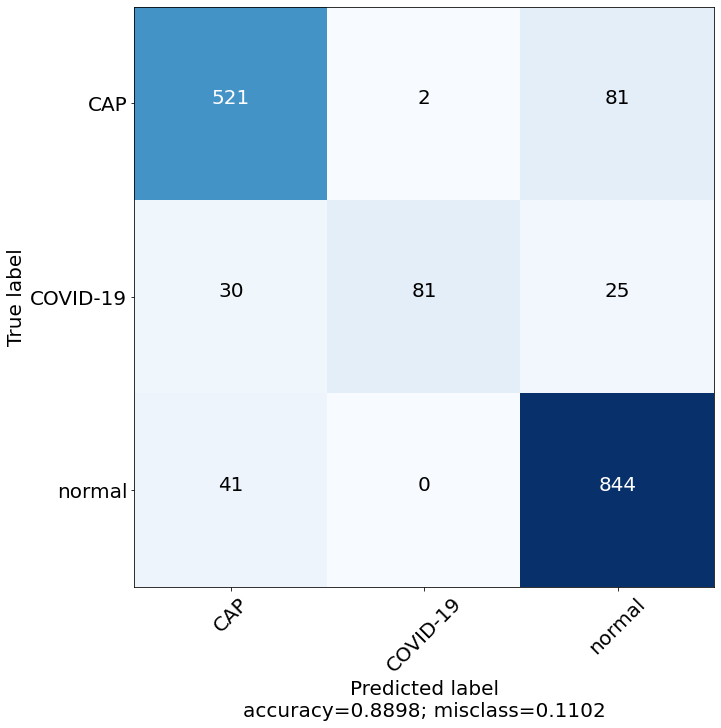

In [23]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

labels = []

label = test_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

for k,v in indexlabel.items():
    labels.append(v)

from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.savefig('/content/drive/My Drive/data_v3/extracted_features/confusion_marix.png', bbox_inches='tight', dpi = 100) 


plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=labels, title=' ')

In [24]:

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
y_pred=predictions
y_pred_probabilities=y_pred

# y_pred = np.argmax(y_pred,axis = 1) 
y_actual = y_true

classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)

confusion_mtx = confusion_matrix(y_actual, y_pred) 
print(confusion_mtx)
target_names = classnames
print(classification_report(y_actual, y_pred, target_names=target_names))

[[521   2  81]
 [ 30  81  25]
 [ 41   0 844]]
              precision    recall  f1-score   support

         CAP       0.88      0.86      0.87       604
    COVID-19       0.98      0.60      0.74       136
      normal       0.89      0.95      0.92       885

    accuracy                           0.89      1625
   macro avg       0.91      0.80      0.84      1625
weighted avg       0.89      0.89      0.89      1625



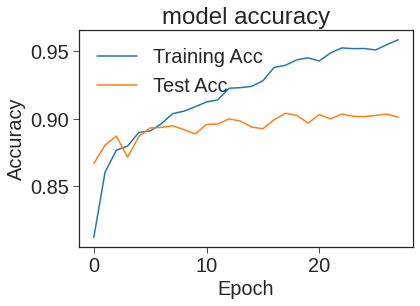

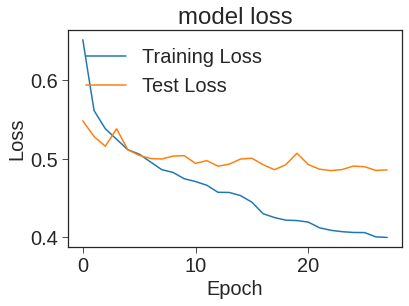

<Figure size 432x288 with 0 Axes>

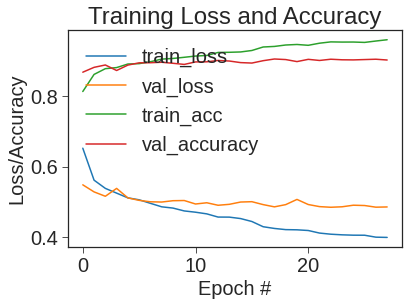

In [26]:
plt.style.use("seaborn-ticks")

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Acc', 'Test Acc'], loc='upper left')
plt.show()


# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Test Loss'], loc='upper left')
plt.show()
plt.savefig('/content/drive/My Drive/data_v3/extracted_features/model_pogress.png', bbox_inches='tight', dpi = 100) 

plt.figure()
N = len(history.history['accuracy'])
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_accuracy")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")
plt.savefig('/content/drive/My Drive/data_v3/extracted_features/loss.png', bbox_inches='tight', dpi = 100) 